In [26]:
#! pip install databento

In [48]:
import pandas as pd
import databento as db
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Data Preprocess and Self-impact Analysis of 5 stocks

## 1.1 Data and Self-impact Analysis for AMGN

### Generate OFI of AMGN

In [32]:
# Initialize the historical client
client = db.Historical(key="db-sXjeRacfqATP4qm4C6QJcxdxepMkt")

# Request data for each 7-day interval
# Data for 2024-12-04 to 2024-12-11
data_amgn_1 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AMGN",
    start=pd.Timestamp("2024-12-04T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-11T00:00", tz="US/Eastern"),
)
symbology_1 = data_amgn_1.request_symbology(client)
data_amgn_1.insert_symbology_json(symbology_1)
data_amgn_1 = data_amgn_1.to_df(tz="US/Eastern")

# Data for 2024-12-11 to 2024-12-18
data_amgn_2 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AMGN",
    start=pd.Timestamp("2024-12-11T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-18T00:00", tz="US/Eastern"),
)
symbology_2 = data_amgn_2.request_symbology(client)
data_amgn_2.insert_symbology_json(symbology_2)
data_amgn_2 = data_amgn_2.to_df(tz="US/Eastern")

# Data for 2024-12-18 to 2024-12-25
data_amgn_3 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AMGN",
    start=pd.Timestamp("2024-12-18T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-25T00:00", tz="US/Eastern"),
)
symbology_3 = data_amgn_3.request_symbology(client)
data_amgn_3.insert_symbology_json(symbology_3)
data_amgn_3 = data_amgn_3.to_df(tz="US/Eastern")

# Data for 2024-12-25 to 2025-01-01
data_amgn_4 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AMGN",
    start=pd.Timestamp("2024-12-25T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-01T00:00", tz="US/Eastern"),
)
symbology_4 = data_amgn_4.request_symbology(client)
data_amgn_4.insert_symbology_json(symbology_4)
data_amgn_4 = data_amgn_4.to_df(tz="US/Eastern")

# Data for 2025-01-01 to 2025-01-03
data_amgn_5 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AMGN",
    start=pd.Timestamp("2025-01-01T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-03T23:00", tz="US/Eastern"),
)
symbology_5 = data_amgn_5.request_symbology(client)
data_amgn_5.insert_symbology_json(symbology_5)
data_amgn_5 = data_amgn_5.to_df(tz="US/Eastern")

# Concatenate all dataframes into one
data_amgn = pd.concat([data_amgn_1, data_amgn_2, data_amgn_3, data_amgn_4, data_amgn_5], ignore_index=True)

In [33]:
data_amgn.to_csv('data_amgn.csv')

In [41]:
# generate OF for amgn
data_amgn1 = data_amgn 

levels = range(5)  # 5 levels，from bid_px_00 to bid_px_04

# 初始化 OF_bid 和 OF_ask 列
for m in levels:
    data_amgn1[f'OF_bid_{m:02d}_amgn'] = 0  # 初始化买单 OF_bid 列
    data_amgn1[f'OF_ask_{m:02d}_amgn'] = 0  # 初始化卖单 OF_ask 列

# get OF_bid 和 OF_ask
for m in levels:
    bid_px_col = f'bid_px_{m:02d}'  
    ask_px_col = f'ask_px_{m:02d}'  
    bid_sz_col = f'bid_sz_{m:02d}'  
    ask_sz_col = f'ask_sz_{m:02d}'  

    prev_bid_px = data_amgn1[bid_px_col].shift()
    prev_ask_px = data_amgn1[ask_px_col].shift()
    prev_bid_sz = data_amgn1[bid_sz_col].shift()
    prev_ask_sz = data_amgn1[ask_sz_col].shift()

    data_amgn1[f'OF_bid_{m:02d}_amgn'] = (
        data_amgn1[bid_sz_col].where(data_amgn1[bid_px_col] > prev_bid_px, 0) +  # 如果买价上涨
        (data_amgn1[bid_sz_col] - prev_bid_sz).where(data_amgn1[bid_px_col] == prev_bid_px, 0) +  # 如果买价不变
        (-data_amgn1[bid_sz_col]).where(data_amgn1[bid_px_col] < prev_bid_px, 0)  # 如果买价下跌
    )

    data_amgn1[f'OF_ask_{m:02d}_amgn'] = (
        (-data_amgn1[ask_sz_col]).where(data_amgn1[ask_px_col] > prev_ask_px, 0) +  # 如果卖价上涨
        (data_amgn1[ask_sz_col] - prev_ask_sz).where(data_amgn1[ask_px_col] == prev_ask_px, 0) +  # 如果卖价不变
        (data_amgn1[ask_sz_col]).where(data_amgn1[ask_px_col] < prev_ask_px, 0)  # 如果卖价下跌
    )



#Generate deeper-level OFI for amgn
data_amgn2 = data_amgn1  

data_amgn2['ts_event'] = pd.to_datetime(data_amgn2['ts_event'])
data_amgn2 = data_amgn2.set_index('ts_event')

levels = range(5)

result_amgn = pd.DataFrame()

# OFI by level for every minute
for m in levels:
    of_bid_col = f'OF_bid_{m:02d}_amgn'
    of_ask_col = f'OF_ask_{m:02d}_amgn'
    ofi_col = f'OFI_{m:02d}_amgn'

    # sum OFI by level and minute
    result_amgn[ofi_col] = (data_amgn2[of_bid_col] - data_amgn2[of_ask_col]).resample('1min').sum()

# Avg_Depth_Sum by minute
avg_depth_sum_amgn = []
for m in levels:
    bid_sz_col = f'bid_sz_{m:02d}'
    ask_sz_col = f'ask_sz_{m:02d}'

    # calculate (Bid_Size + Ask_Size) / (2 * number of events)
    bid_ask_sum = (data_amgn2[bid_sz_col] + data_amgn2[ask_sz_col]).resample('1min').sum()
    event_count = data_amgn2[bid_sz_col].resample('1min').count()

    avg_depth_sum_amgn.append(bid_ask_sum / (2 * event_count))

# Avg_Depth_Sum of all levels
result_amgn['Avg_Depth_Sum_amgn'] = sum(avg_depth_sum_amgn) / len(levels)

for m in range(5):  
    ofi_col = f'OFI_{m:02d}_amgn'  
    norm_col = f'Normalized_OFI_{m:02d}_amgn'  

    # normalize OFI
    result_amgn[norm_col] = result_amgn[ofi_col] / result_amgn['Avg_Depth_Sum_amgn']

# delet NaN 
result_amgn = result_amgn.dropna()


# Use PCA method to integrate OFI for amgn

normalized_cols_amgn = [f'Normalized_OFI_{m:02d}_amgn' for m in range(5)]
normalized_data_amgn = result_amgn[normalized_cols_amgn]

normalized_data_amgn = normalized_data_amgn.dropna()

# normalization
scaler_amgn = StandardScaler()
normalized_data_scaled_amgn = scaler_amgn.fit_transform(normalized_data_amgn)

#  PCA analysis
pca_amgn = PCA(n_components=1)  # 只提取第一主成分
principal_component_amgn = pca_amgn.fit_transform(normalized_data_scaled_amgn)

result_amgn = result_amgn.copy()
result_amgn['PCA_OFI_amgn'] = principal_component_amgn


# Generate return for amgn
data_amgn3 = data_amgn  

data_amgn3['ts_event'] = pd.to_datetime(data_amgn3['ts_event'])

data_amgn3['ts_event_min_amgn'] = data_amgn3['ts_event'].dt.floor('min')  # 对齐到分钟

minute_data_amgn = data_amgn3.groupby('ts_event_min_amgn').first().reset_index()

minute_data_amgn['mid_price_amgn'] = (
    (minute_data_amgn['bid_px_00'] + minute_data_amgn['ask_px_00']) / 2
)

# log return
h = 1  
minute_data_amgn['log_return_1min_amgn'] = (
    np.log(minute_data_amgn['mid_price_amgn']) - 
    np.log(minute_data_amgn['mid_price_amgn'].shift(h))
)

# delete NaN 值
minute_data_amgn = minute_data_amgn.dropna(subset=['log_return_1min_amgn'])

# combine data
pca_data_amgn = result_amgn  #

minute_data_amgn['ts_event_min_amgn'] = pd.to_datetime(minute_data_amgn['ts_event_min_amgn'])  # 确保时间格式
pca_data_amgn.index = pd.to_datetime(pca_data_amgn.index)  # 将索引转为 datetime 格式

# merge dataset
merged_data_amgn = pd.merge(
    minute_data_amgn,
    pca_data_amgn[['PCA_OFI_amgn']], 
    left_on='ts_event_min_amgn',
    right_index=True,
    how='inner'
)

merged_data_amgn.to_csv('merged_data_amgn.csv')

### Self-impact Analysis of AMGN

In [36]:
import statsmodels.api as sm

merged_data_amgn['ts_event_min_amgn'] = pd.to_datetime(merged_data_amgn['ts_event_min_amgn'])

# time range
start_time = "10:00"
end_time = "15:30"

# filter record
filtered_data_amgn = merged_data_amgn[
    (merged_data_amgn['ts_event_min_amgn'].dt.time >= pd.to_datetime(start_time).time()) &
    (merged_data_amgn['ts_event_min_amgn'].dt.time <= pd.to_datetime(end_time).time())
]

y_amgn = filtered_data_amgn['log_return_1min_amgn']  # 因变量：1分钟对数收益
X_amgn = filtered_data_amgn['PCA_OFI_amgn']         # 自变量：PCA_OFI
X_amgn = sm.add_constant(X_amgn)

# OLS regression
model_amgn = sm.OLS(y_amgn, X_amgn)
results_amgn = model_amgn.fit()

In [37]:
results_amgn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_return_1min_amgn   R-squared:                       0.008
Model:                              OLS   Adj. R-squared:                  0.008
Method:                   Least Squares   F-statistic:                     53.45
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):           2.96e-13
Time:                          12:05:34   Log-Likelihood:                 41995.
No. Observations:                  6820   AIC:                        -8.399e+04
Df Residuals:                      6818   BIC:                        -8.397e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.169e-06    6.2e-06     -0.350      0.727   -1.43e-05    9.99e-06
PCA_OFI_amgn -2.842e-05   3.89e-06     -7.311      0.000    -3.6e-05   -2.08e-05
==============================================================================
Omnibus:                     1002.216   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13542.340
Skew:                          -0.216   Prob(JB):                         0.00
Kurtosis:                       9.890   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 1.2 Data and Self-impact Analysis for AAPL

In [5]:
# Data for 2024-12-04 to 2024-12-11
data_aapl_1 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AAPL",
    start=pd.Timestamp("2024-12-04T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-11T00:00", tz="US/Eastern"),
)
symbology_1 = data_aapl_1.request_symbology(client)
data_aapl_1.insert_symbology_json(symbology_1)
data_aapl_1 = data_aapl_1.to_df(tz="US/Eastern")

# Data for 2024-12-11 to 2024-12-18
data_aapl_2 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AAPL",
    start=pd.Timestamp("2024-12-11T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-18T00:00", tz="US/Eastern"),
)
symbology_2 = data_aapl_2.request_symbology(client)
data_aapl_2.insert_symbology_json(symbology_2)
data_aapl_2 = data_aapl_2.to_df(tz="US/Eastern")

# Data for 2024-12-18 to 2024-12-25
data_aapl_3 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AAPL",
    start=pd.Timestamp("2024-12-18T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-25T00:00", tz="US/Eastern"),
)
symbology_3 = data_aapl_3.request_symbology(client)
data_aapl_3.insert_symbology_json(symbology_3)
data_aapl_3 = data_aapl_3.to_df(tz="US/Eastern")

# Data for 2024-12-25 to 2025-01-01
data_aapl_4 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AAPL",
    start=pd.Timestamp("2024-12-25T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-01T00:00", tz="US/Eastern"),
)
symbology_4 = data_aapl_4.request_symbology(client)
data_aapl_4.insert_symbology_json(symbology_4)
data_aapl_4 = data_aapl_4.to_df(tz="US/Eastern")

# Data for 2025-01-01 to 2025-01-03
data_aapl_5 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="AAPL",
    start=pd.Timestamp("2025-01-01T00:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-03T23:00", tz="US/Eastern"),
)
symbology_5 = data_aapl_5.request_symbology(client)
data_aapl_5.insert_symbology_json(symbology_5)
data_aapl_5 = data_aapl_5.to_df(tz="US/Eastern")

# Concatenate all dataframes into one
data_aapl = pd.concat([data_aapl_1, data_aapl_2, data_aapl_3, data_aapl_4, data_aapl_5], ignore_index=True)

In [6]:
data_aapl.to_csv('data_aapl.csv')

In [7]:
# Generate OF for aapl
data_aapl1 = data_aapl  

levels = range(5)  

for m in levels:
    data_aapl1[f'OF_bid_{m:02d}_aapl'] = 0  
    data_aapl1[f'OF_ask_{m:02d}_aapl'] = 0  

for m in levels:
    bid_px_col = f'bid_px_{m:02d}'  
    ask_px_col = f'ask_px_{m:02d}' 
    bid_sz_col = f'bid_sz_{m:02d}'  
    ask_sz_col = f'ask_sz_{m:02d}'  

    prev_bid_px = data_aapl1[bid_px_col].shift()
    prev_ask_px = data_aapl1[ask_px_col].shift()
    prev_bid_sz = data_aapl1[bid_sz_col].shift()
    prev_ask_sz = data_aapl1[ask_sz_col].shift()

    data_aapl1[f'OF_bid_{m:02d}_aapl'] = (
        data_aapl1[bid_sz_col].where(data_aapl1[bid_px_col] > prev_bid_px, 0) +  # 如果买价上涨
        (data_aapl1[bid_sz_col] - prev_bid_sz).where(data_aapl1[bid_px_col] == prev_bid_px, 0) +  # 如果买价不变
        (-data_aapl1[bid_sz_col]).where(data_aapl1[bid_px_col] < prev_bid_px, 0)  # 如果买价下跌
    )

    data_aapl1[f'OF_ask_{m:02d}_aapl'] = (
        (-data_aapl1[ask_sz_col]).where(data_aapl1[ask_px_col] > prev_ask_px, 0) +  # 如果卖价上涨
        (data_aapl1[ask_sz_col] - prev_ask_sz).where(data_aapl1[ask_px_col] == prev_ask_px, 0) +  # 如果卖价不变
        (data_aapl1[ask_sz_col]).where(data_aapl1[ask_px_col] < prev_ask_px, 0)  # 如果卖价下跌
    )



# Generate deeper-level OFI for aapl
data_aapl2 = data_aapl1  

data_aapl2['ts_event'] = pd.to_datetime(data_aapl2['ts_event'])
data_aapl2 = data_aapl2.set_index('ts_event')

levels = range(5)

result_aapl = pd.DataFrame()

for m in levels:
    of_bid_col = f'OF_bid_{m:02d}_aapl'
    of_ask_col = f'OF_ask_{m:02d}_aapl'
    ofi_col = f'OFI_{m:02d}_aapl'

    result_aapl[ofi_col] = (data_aapl2[of_bid_col] - data_aapl2[of_ask_col]).resample('1min').sum()

avg_depth_sum_aapl = []
for m in levels:
    bid_sz_col = f'bid_sz_{m:02d}'
    ask_sz_col = f'ask_sz_{m:02d}'

    bid_ask_sum = (data_aapl2[bid_sz_col] + data_aapl2[ask_sz_col]).resample('1min').sum()
    event_count = data_aapl2[bid_sz_col].resample('1min').count()

    avg_depth_sum_aapl.append(bid_ask_sum / (2 * event_count))

result_aapl['Avg_Depth_Sum_aapl'] = sum(avg_depth_sum_aapl) / len(levels)

for m in range(5):  
    ofi_col = f'OFI_{m:02d}_aapl'  
    norm_col = f'Normalized_OFI_{m:02d}_aapl'  

    result_aapl[norm_col] = result_aapl[ofi_col] / result_aapl['Avg_Depth_Sum_aapl']

result_aapl = result_aapl.dropna()



# Use PCA method to integrate OFI for aapl
normalized_cols_aapl = [f'Normalized_OFI_{m:02d}_aapl' for m in range(5)]
normalized_data_aapl = result_aapl[normalized_cols_aapl]

normalized_data_aapl = normalized_data_aapl.dropna()

scaler_aapl = StandardScaler()
normalized_data_scaled_aapl = scaler_aapl.fit_transform(normalized_data_aapl)

pca_aapl = PCA(n_components=1)  
principal_component_aapl = pca_aapl.fit_transform(normalized_data_scaled_aapl)

result_aapl = result_aapl.copy()
result_aapl['PCA_OFI_aapl'] = principal_component_aapl


# Generate return for aapl
data_aapl3 = data_aapl  

data_aapl3['ts_event'] = pd.to_datetime(data_aapl3['ts_event'])
）
data_aapl3['ts_event_min_aapl'] = data_aapl3['ts_event'].dt.floor('min')  

data_aapl3['mid_price_aapl'] = (data_aapl3['bid_px_00'] + data_aapl3['ask_px_00']) / 2

minute_data_aapl = data_aapl3.groupby('ts_event_min_aapl')['mid_price_aapl'].mean().reset_index()

h = 1  
minute_data_aapl['log_return_1min_aapl'] = (
    np.log(minute_data_aapl['mid_price_aapl']) - np.log(minute_data_aapl['mid_price_aapl'].shift(h))
)

minute_data_aapl = minute_data_aapl.dropna(subset=['log_return_1min_aapl'])

pca_data_aapl = result_aapl  


minute_data_aapl['ts_event_min_aapl'] = pd.to_datetime(minute_data_aapl['ts_event_min_aapl'])  

pca_data_aapl.index = pd.to_datetime(pca_data_aapl.index)  

merged_data_aapl = pd.merge(
    minute_data_aapl,
    pca_data_aapl[['PCA_OFI_aapl']],  
    left_on='ts_event_min_aapl',
    right_index=True,
    how='inner'
)

merged_data_aapl.to_csv('merged_data_aapl.csv', index=False)

In [16]:
merged_data_aapl['ts_event_min_aapl'] = pd.to_datetime(merged_data_aapl['ts_event_min_aapl'])

start_time = "10:00"
end_time = "15:30"

filtered_data_aapl = merged_data_aapl[
    (merged_data_aapl['ts_event_min_aapl'].dt.time >= pd.to_datetime(start_time).time()) &
    (merged_data_aapl['ts_event_min_aapl'].dt.time <= pd.to_datetime(end_time).time())
]

y_aapl = filtered_data_aapl['log_return_1min_aapl']  
X_aapl = filtered_data_aapl['PCA_OFI_aapl']         
X_aapl = sm.add_constant(X_aapl)

model_aapl = sm.OLS(y_aapl, X_aapl)
results_aapl = model_aapl.fit()
print(results_aapl.summary())

                             OLS Regression Results                             
Dep. Variable:     log_return_1min_aapl   R-squared:                       0.022
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     157.4
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):           1.03e-35
Time:                          12:26:31   Log-Likelihood:                 45611.
No. Observations:                  6931   AIC:                        -9.122e+04
Df Residuals:                      6929   BIC:                        -9.120e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.871e-06   4.

## 1.3 Data and Self-impact Analysis for TSLA

In [4]:
#split dataset since it's too large to download at one time.
# Function to fetch data for a given date range
def fetch_data(start_date, end_date):
    data = client.timeseries.get_range(
        dataset="XNAS.ITCH",
        schema="MBP-10",
        symbols="TSLA",
        start=pd.Timestamp(start_date, tz="US/Eastern"),
        end=pd.Timestamp(end_date, tz="US/Eastern"),
    )
    symbology = data.request_symbology(client)
    data.insert_symbology_json(symbology)
    return data.to_df(tz="US/Eastern")

In [5]:
# Fetch data for each time period
data_tsla_1 = fetch_data("2024-12-04T10:00", "2024-12-06T15:30")

#  10:00 to 15:30 
if not isinstance(data_tsla_1.index, pd.DatetimeIndex):
    data_tsla_1.index = pd.to_datetime(data_tsla_1.index)
data_tsla_1 = data_tsla_1.between_time("10:00", "15:30")
data_tsla_1.to_csv('data_tsla2.csv')

In [7]:
data_tsla_1.to_csv('data_tsla1.csv')

In [8]:
data_tsla_2 = fetch_data("2024-12-09T10:00", "2024-12-13T15:30")
if not isinstance(data_tsla_2.index, pd.DatetimeIndex):
    data_tsla_2.index = pd.to_datetime(data_tsla_2.index)
data_tsla_2 = data_tsla_2.between_time("10:00", "15:30")
data_tsla_2.to_csv('data_tsla2.csv')

In [16]:
data_tsla_3 = fetch_data("2024-12-16T10:00", "2024-12-20T15:30")
if not isinstance(data_tsla_3.index, pd.DatetimeIndex):
    data_tsla_3.index = pd.to_datetime(data_tsla_3.index)
data_tsla_3 = data_tsla_3.between_time("10:00", "15:30")
data_tsla_3.to_csv('data_tsla3.csv')

In [14]:
data_tsla_4 = fetch_data("2024-12-23T10:00", "2024-12-27T15:30")
if not isinstance(data_tsla_4.index, pd.DatetimeIndex):
    data_tsla_4.index = pd.to_datetime(data_tsla_4.index)
data_tsla_4 = data_tsla_4.between_time("10:00", "15:30")
data_tsla_4.to_csv('data_tsla4.csv')

In [15]:
data_tsla_5 = fetch_data("2024-12-30T10:00", "2025-01-03T15:30")
if not isinstance(data_tsla_5.index, pd.DatetimeIndex):
    data_tsla_5.index = pd.to_datetime(data_tsla_5.index)
data_tsla_5 = data_tsla_5.between_time("10:00", "15:30")
data_tsla_5.to_csv('data_tsla5.csv')

In [17]:
# Concatenate all dataframes into one
data_tsla = pd.concat([data_tsla_1, data_tsla_2, data_tsla_3, data_tsla_4, data_tsla_5], ignore_index=True)

                             ts_event  rtype  publisher_id  instrument_id  \
0 2024-12-04 10:00:00.006112448-05:00     10             2          16244   
1 2024-12-04 10:00:00.006228007-05:00     10             2          16244   
2 2024-12-04 10:00:00.006295836-05:00     10             2          16244   
3 2024-12-04 10:00:00.006443337-05:00     10             2          16244   
4 2024-12-04 10:00:00.006511172-05:00     10             2          16244   

  action side  depth   price  size  flags  ...  ask_sz_08  bid_ct_08  \
0      C    A      0  351.04    25    130  ...          4          3   
1      C    B      0  350.82    25    128  ...          4          3   
2      A    A      0  350.97    25    128  ...        128          3   
3      C    B      6  350.74    35    128  ...        128          3   
4      A    A      0  350.97    24    128  ...        128          3   

   ask_ct_08  bid_px_09  ask_px_09  bid_sz_09  ask_sz_09  bid_ct_09  \
0          1     350.71     351.1

In [ ]:
data_tsla=pd.read_csv('data_tsla.csv')

In [20]:
# Generate OF for tsla
data_tsla01 = data_tsla  

levels = range(5)  # 5 levels from bid_px_00 to bid_px_04

# Initialize OF_bid and OF_ask columns
for m in levels:
    data_tsla01[f'OF_bid_{m:02d}_tsla'] = 0  # Initialize bid order flow columns
    data_tsla01[f'OF_ask_{m:02d}_tsla'] = 0  # Initialize ask order flow columns

# Calculate OF_bid and OF_ask for each level
for m in levels:
    bid_px_col = f'bid_px_{m:02d}'  # Bid price column name
    ask_px_col = f'ask_px_{m:02d}'  # Ask price column name
    bid_sz_col = f'bid_sz_{m:02d}'  # Bid size column name
    ask_sz_col = f'ask_sz_{m:02d}'  # Ask size column name

    # Get previous row values
    prev_bid_px = data_tsla01[bid_px_col].shift()
    prev_ask_px = data_tsla01[ask_px_col].shift()
    prev_bid_sz = data_tsla01[bid_sz_col].shift()
    prev_ask_sz = data_tsla01[ask_sz_col].shift()

    # Calculate bid order flow (OF_bid)
    data_tsla01[f'OF_bid_{m:02d}_tsla'] = (
        data_tsla01[bid_sz_col].where(data_tsla01[bid_px_col] > prev_bid_px, 0) +  # If bid price increases
        (data_tsla01[bid_sz_col] - prev_bid_sz).where(data_tsla01[bid_px_col] == prev_bid_px, 0) +  # If bid price remains the same
        (-data_tsla01[bid_sz_col]).where(data_tsla01[bid_px_col] < prev_bid_px, 0)  # If bid price decreases
    )

    # Calculate ask order flow (OF_ask)
    data_tsla01[f'OF_ask_{m:02d}_tsla'] = (
        (-data_tsla01[ask_sz_col]).where(data_tsla01[ask_px_col] > prev_ask_px, 0) +  # If ask price increases
        (data_tsla01[ask_sz_col] - prev_ask_sz).where(data_tsla01[ask_px_col] == prev_ask_px, 0) +  # If ask price remains the same
        (data_tsla01[ask_sz_col]).where(data_tsla01[ask_px_col] < prev_ask_px, 0)  # If ask price decreases
    )

In [21]:
# Generate deeper-level OFI for tsla
data_tsla02 = data_tsla01  # Use a variable name with a suffix

# Convert ts_event to datetime format and set it as the index
data_tsla02['ts_event'] = pd.to_datetime(data_tsla02['ts_event'])
data_tsla02 = data_tsla02.set_index('ts_event')

# Define levels range
levels = range(5)

# Initialize a DataFrame to store results
result_tsla = pd.DataFrame()

# Calculate OFI for each level per minute
for m in levels:
    of_bid_col = f'OF_bid_{m:02d}_tsla'
    of_ask_col = f'OF_ask_{m:02d}_tsla'
    ofi_col = f'OFI_{m:02d}_tsla'

    # Aggregate OFI per minute for each level
    result_tsla[ofi_col] = (data_tsla02[of_bid_col] - data_tsla02[of_ask_col]).resample('1min').sum()

# Calculate Avg_Depth_Sum per minute
avg_depth_sum_tsla = []
for m in levels:
    bid_sz_col = f'bid_sz_{m:02d}'
    ask_sz_col = f'ask_sz_{m:02d}'

    # Calculate (Bid_Size + Ask_Size) / (2 * event count) per minute
    bid_ask_sum = (data_tsla02[bid_sz_col] + data_tsla02[ask_sz_col]).resample('1min').sum()
    event_count = data_tsla02[bid_sz_col].resample('1min').count()

    # Calculate Avg_Depth for the level and append to the list
    avg_depth_sum_tsla.append(bid_ask_sum / (2 * event_count))

# Calculate Avg_Depth_Sum across all levels
result_tsla['Avg_Depth_Sum_tsla'] = sum(avg_depth_sum_tsla) / len(levels)

# Compute normalized OFI for each level based on Avg_Depth_Sum
for m in range(5):
    ofi_col = f'OFI_{m:02d}_tsla'  # Original OFI column
    norm_col = f'Normalized_OFI_{m:02d}_tsla'  # Normalized OFI column

    # Compute normalized OFI
    result_tsla[norm_col] = result_tsla[ofi_col] / result_tsla['Avg_Depth_Sum_tsla']

# Drop rows with NaN values
result_tsla = result_tsla.dropna()

# Use PCA method to integrate OFI for tsla
# Extract columns for PCA
normalized_cols_tsla = [f'Normalized_OFI_{m:02d}_tsla' for m in range(5)]
normalized_data_tsla = result_tsla[normalized_cols_tsla]

# Check and handle NaN values if any
normalized_data_tsla = normalized_data_tsla.dropna()

# Standardize data (mean = 0, standard deviation = 1)
scaler_tsla = StandardScaler()
normalized_data_scaled_tsla = scaler_tsla.fit_transform(normalized_data_tsla)

# Perform PCA analysis
pca_tsla = PCA(n_components=1)  # Extract only the first principal component
principal_component_tsla = pca_tsla.fit_transform(normalized_data_scaled_tsla)

# Ensure result_tsla is a copy to avoid warnings
result_tsla = result_tsla.copy()
result_tsla['PCA_OFI_tsla'] = principal_component_tsla

In [22]:
# Generate return for tsla
data_tsla03 = data_tsla  # Use a variable name with a suffix

# Ensure ts_event is in datetime format
data_tsla03['ts_event'] = pd.to_datetime(data_tsla03['ts_event'])

# Align time to the nearest minute (flooring to minute)
data_tsla03['ts_event_min_tsla'] = data_tsla03['ts_event'].dt.floor('min')

# Calculate Mid-Price using bid and ask from the first level
data_tsla03['mid_price_tsla'] = (data_tsla03['bid_px_00'] + data_tsla03['ask_px_00']) / 2

# Compute average Mid-Price per minute
minute_data_tsla = data_tsla03.groupby('ts_event_min_tsla')['mid_price_tsla'].mean().reset_index()

# Calculate log returns
time_window = 1  # Time window is 1 minute
minute_data_tsla['log_return_1min_tsla'] = (
    np.log(minute_data_tsla['mid_price_tsla']) - np.log(minute_data_tsla['mid_price_tsla'].shift(time_window))
)

# Drop NaN values
minute_data_tsla = minute_data_tsla.dropna(subset=['log_return_1min_tsla'])

# Merge PCA data with minute-level data
pca_data_tsla = result_tsla  # Use the PCA data table with a suffix

# Ensure ts_event_min_tsla in minute_data_tsla is in datetime format
minute_data_tsla['ts_event_min_tsla'] = pd.to_datetime(minute_data_tsla['ts_event_min_tsla'])

# Ensure the index of pca_data_tsla is in datetime format
pca_data_tsla.index = pd.to_datetime(pca_data_tsla.index)

# Merge the two tables (left table is minute_data_tsla, right table uses index as key)
merged_data_tsla = pd.merge(
    minute_data_tsla,
    pca_data_tsla[['PCA_OFI_tsla']],  # Extract only the PCA column
    left_on='ts_event_min_tsla',
    right_index=True,
    how='inner'
)

print(merged_data_tsla)
merged_data_tsla.to_csv('merged_data_tsla')

             ts_event_min_tsla  mid_price_tsla  log_return_1min_tsla  \
1    2024-12-04 10:01:00-05:00      350.336970             -0.001347   
2    2024-12-04 10:02:00-05:00      349.872019             -0.001328   
3    2024-12-04 10:03:00-05:00      350.090393              0.000624   
4    2024-12-04 10:04:00-05:00      350.344544              0.000726   
5    2024-12-04 10:05:00-05:00      350.188826             -0.000445   
...                        ...             ...                   ...   
6925 2025-01-03 15:25:00-05:00      407.888084             -0.001159   
6926 2025-01-03 15:26:00-05:00      407.787295             -0.000247   
6927 2025-01-03 15:27:00-05:00      407.971319              0.000451   
6928 2025-01-03 15:28:00-05:00      408.480290              0.001247   
6929 2025-01-03 15:29:00-05:00      408.358755             -0.000298   

      PCA_OFI_tsla  
1        -0.575423  
2        -0.449404  
3         1.878719  
4         0.430043  
5         0.200818  
...      

In [28]:
merged_data_tsla['ts_event_min_tsla'] = pd.to_datetime(merged_data_tsla['ts_event_min_tsla'])

start_time = "10:30"
end_time = "15:30"
filtered_data_tsla = merged_data_tsla[
    (merged_data_tsla['ts_event_min_tsla'].dt.time >= pd.to_datetime(start_time).time()) &
    (merged_data_tsla['ts_event_min_tsla'].dt.time <= pd.to_datetime(end_time).time())]


y_tsla = filtered_data_tsla['log_return_1min_tsla']  
X_tsla = filtered_data_tsla['PCA_OFI_tsla']         
X_tsla = sm.add_constant(X_tsla)

model_tsla = sm.OLS(y_tsla, X_tsla)
results_tsla = model_tsla.fit()
print(results_tsla.summary())

                             OLS Regression Results                             
Dep. Variable:     log_return_1min_tsla   R-squared:                       0.161
Model:                              OLS   Adj. R-squared:                  0.161
Method:                   Least Squares   F-statistic:                     1207.
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):          3.42e-242
Time:                          11:58:00   Log-Likelihood:                 34516.
No. Observations:                  6300   AIC:                        -6.903e+04
Df Residuals:                      6298   BIC:                        -6.901e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.695e-06   1.

## 1.4 Data and Self-impact Analysis for JPM

In [1]:
# Data for 2024-12-04 to 2024-12-11
data_jpm_1 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="JPM",  # Changed from TSLA to JPM
    start=pd.Timestamp("2024-12-04T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-11T15:30", tz="US/Eastern"),
)
symbology_1 = data_jpm_1.request_symbology(client)
data_jpm_1.insert_symbology_json(symbology_1)
data_jpm_1 = data_jpm_1.to_df(tz="US/Eastern")

# Data for 2024-12-11 to 2024-12-18
data_jpm_2 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="JPM",  # Changed from TSLA to JPM
    start=pd.Timestamp("2024-12-11T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-18T15:30", tz="US/Eastern"),
)
symbology_2 = data_jpm_2.request_symbology(client)
data_jpm_2.insert_symbology_json(symbology_2)
data_jpm_2 = data_jpm_2.to_df(tz="US/Eastern")

# Data for 2024-12-18 to 2024-12-25
data_jpm_3 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="JPM",  # Changed from TSLA to JPM
    start=pd.Timestamp("2024-12-18T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-25T15:30", tz="US/Eastern"),
)
symbology_3 = data_jpm_3.request_symbology(client)
data_jpm_3.insert_symbology_json(symbology_3)
data_jpm_3 = data_jpm_3.to_df(tz="US/Eastern")

# Data for 2024-12-25 to 2025-01-01
data_jpm_4 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="JPM",  # Changed from TSLA to JPM
    start=pd.Timestamp("2024-12-25T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-01T15:30", tz="US/Eastern"),
)
symbology_4 = data_jpm_4.request_symbology(client)
data_jpm_4.insert_symbology_json(symbology_4)
data_jpm_4 = data_jpm_4.to_df(tz="US/Eastern")

# Data for 2025-01-01 to 2025-01-03
data_jpm_5 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="JPM",  # Changed from TSLA to JPM
    start=pd.Timestamp("2025-01-01T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-03T15:30", tz="US/Eastern"),
)
symbology_5 = data_jpm_5.request_symbology(client)
data_jpm_5.insert_symbology_json(symbology_5)
data_jpm_5 = data_jpm_5.to_df(tz="US/Eastern")

# Concatenate all dataframes into one
data_jpm = pd.concat([data_jpm_1, data_jpm_2, data_jpm_3, data_jpm_4, data_jpm_5], ignore_index=True)

In [3]:
data_jpm.to_csv('data_jpm.csv')

In [4]:
# Generate OF for jpm
data_jpm1 = data_jpm  # Use a new variable name

# Define levels range
levels = range(5)  # 5 levels from bid_px_00 to bid_px_04

# Initialize OF_bid and OF_ask columns
for m in levels:
    data_jpm1[f'OF_bid_{m:02d}_jpm'] = 0  # Initialize bid order flow columns
    data_jpm1[f'OF_ask_{m:02d}_jpm'] = 0  # Initialize ask order flow columns

# Calculate OF_bid and OF_ask for each level
for m in levels:
    bid_px_col = f'bid_px_{m:02d}'  # Bid price column name
    ask_px_col = f'ask_px_{m:02d}'  # Ask price column name
    bid_sz_col = f'bid_sz_{m:02d}'  # Bid size column name
    ask_sz_col = f'ask_sz_{m:02d}'  # Ask size column name

    # Get previous row values
    prev_bid_px = data_jpm1[bid_px_col].shift()
    prev_ask_px = data_jpm1[ask_px_col].shift()
    prev_bid_sz = data_jpm1[bid_sz_col].shift()
    prev_ask_sz = data_jpm1[ask_sz_col].shift()

    # Calculate bid order flow (OF_bid)
    data_jpm1[f'OF_bid_{m:02d}_jpm'] = (
        data_jpm1[bid_sz_col].where(data_jpm1[bid_px_col] > prev_bid_px, 0) +  # If bid price increases
        (data_jpm1[bid_sz_col] - prev_bid_sz).where(data_jpm1[bid_px_col] == prev_bid_px, 0) +  # If bid price remains the same
        (-data_jpm1[bid_sz_col]).where(data_jpm1[bid_px_col] < prev_bid_px, 0)  # If bid price decreases
    )

    # Calculate ask order flow (OF_ask)
    data_jpm1[f'OF_ask_{m:02d}_jpm'] = (
        (-data_jpm1[ask_sz_col]).where(data_jpm1[ask_px_col] > prev_ask_px, 0) +  # If ask price increases
        (data_jpm1[ask_sz_col] - prev_ask_sz).where(data_jpm1[ask_px_col] == prev_ask_px, 0) +  # If ask price remains the same
        (data_jpm1[ask_sz_col]).where(data_jpm1[ask_px_col] < prev_ask_px, 0)  # If ask price decreases
    )

# Generate deeper-level OFI for jpm
data_jpm2 = data_jpm1  # Use a variable name with a suffix
data_jpm2['ts_event'] = pd.to_datetime(data_jpm2['ts_event'])
data_jpm2 = data_jpm2.set_index('ts_event')

result_jpm = pd.DataFrame()

for m in levels:
    of_bid_col = f'OF_bid_{m:02d}_jpm'
    of_ask_col = f'OF_ask_{m:02d}_jpm'
    ofi_col = f'OFI_{m:02d}_jpm'

    result_jpm[ofi_col] = (data_jpm2[of_bid_col] - data_jpm2[of_ask_col]).resample('1min').sum()

avg_depth_sum_jpm = []
for m in levels:
    bid_sz_col = f'bid_sz_{m:02d}'
    ask_sz_col = f'ask_sz_{m:02d}'
    bid_ask_sum = (data_jpm2[bid_sz_col] + data_jpm2[ask_sz_col]).resample('1min').sum()
    event_count = data_jpm2[bid_sz_col].resample('1min').count()
    avg_depth_sum_jpm.append(bid_ask_sum / (2 * event_count))

result_jpm['Avg_Depth_Sum_jpm'] = sum(avg_depth_sum_jpm) / len(levels)

for m in range(5):
    ofi_col = f'OFI_{m:02d}_jpm'
    norm_col = f'Normalized_OFI_{m:02d}_jpm'
    result_jpm[norm_col] = result_jpm[ofi_col] / result_jpm['Avg_Depth_Sum_jpm']

result_jpm = result_jpm.dropna()

# PCA Integration
normalized_cols_jpm = [f'Normalized_OFI_{m:02d}_jpm' for m in range(5)]
normalized_data_jpm = result_jpm[normalized_cols_jpm].dropna()

scaler_jpm = StandardScaler()
normalized_data_scaled_jpm = scaler_jpm.fit_transform(normalized_data_jpm)

pca_jpm = PCA(n_components=1)
principal_component_jpm = pca_jpm.fit_transform(normalized_data_scaled_jpm)

result_jpm['PCA_OFI_jpm'] = principal_component_jpm

# Generate return for jpm
data_jpm3 = data_jpm
data_jpm3['ts_event'] = pd.to_datetime(data_jpm3['ts_event'])
data_jpm3['ts_event_min_jpm'] = data_jpm3['ts_event'].dt.floor('min')

data_jpm3['mid_price_jpm'] = (data_jpm3['bid_px_00'] + data_jpm3['ask_px_00']) / 2
minute_data_jpm = data_jpm3.groupby('ts_event_min_jpm')['mid_price_jpm'].mean().reset_index()

minute_data_jpm['log_return_1min_jpm'] = (
    np.log(minute_data_jpm['mid_price_jpm']) - np.log(minute_data_jpm['mid_price_jpm'].shift(1))
)
minute_data_jpm = minute_data_jpm.dropna(subset=['log_return_1min_jpm'])

# Merge PCA and return data
pca_data_jpm = result_jpm
minute_data_jpm['ts_event_min_jpm'] = pd.to_datetime(minute_data_jpm['ts_event_min_jpm'])
pca_data_jpm.index = pd.to_datetime(pca_data_jpm.index)

merged_data_jpm = pd.merge(
    minute_data_jpm,
    pca_data_jpm[['PCA_OFI_jpm']],
    left_on='ts_event_min_jpm',
    right_index=True,
    how='inner'
)

print(merged_data_jpm)
merged_data_jpm.to_csv('merged_data_jpm.csv', index=False)

               ts_event_min_jpm  mid_price_jpm  log_return_1min_jpm  \
1     2024-12-04 10:01:00-05:00     244.604973             0.000631   
2     2024-12-04 10:02:00-05:00     244.692569             0.000358   
3     2024-12-04 10:03:00-05:00     244.488374            -0.000835   
4     2024-12-04 10:04:00-05:00     244.202157            -0.001171   
5     2024-12-04 10:05:00-05:00     244.104577            -0.000400   
...                         ...            ...                  ...   
14702 2025-01-03 15:25:00-05:00     242.380012             0.000192   
14703 2025-01-03 15:26:00-05:00     242.398082             0.000075   
14704 2025-01-03 15:27:00-05:00     242.467469             0.000286   
14705 2025-01-03 15:28:00-05:00     242.569721             0.000422   
14706 2025-01-03 15:29:00-05:00     242.593229             0.000097   

       PCA_OFI_jpm  
1         1.967843  
2        -0.982097  
3        -3.840433  
4         0.489041  
5        -2.865869  
...            ...  


In [8]:
merged_data_jpm['ts_event_min_jpm'] = pd.to_datetime(merged_data_jpm['ts_event_min_jpm'])

start_time = "10:00"
end_time = "15:30"
filtered_data_jpm = merged_data_jpm[
    (merged_data_jpm['ts_event_min_jpm'].dt.time >= pd.to_datetime(start_time).time()) &
    (merged_data_jpm['ts_event_min_jpm'].dt.time <= pd.to_datetime(end_time).time())]

y_jpm = filtered_data_jpm['log_return_1min_jpm']  
X_jpm = filtered_data_jpm['PCA_OFI_jpm']         
X_jpm = sm.add_constant(X_jpm)

model_jpm = sm.OLS(y_jpm, X_jpm)
results_jpm = model_jpm.fit()
print(results_jpm.summary())

                             OLS Regression Results                            
Dep. Variable:     log_return_1min_jpm   R-squared:                       0.332
Model:                             OLS   Adj. R-squared:                  0.332
Method:                  Least Squares   F-statistic:                     3393.
Date:                 Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                         01:40:30   Log-Likelihood:                 45009.
No. Observations:                 6816   AIC:                        -9.001e+04
Df Residuals:                     6814   BIC:                        -9.000e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.114e-06   3.97e-06      0

## 1.5 Data and Self-impact Analysis for XOM

In [9]:
# Data for 2024-12-04 to 2024-12-11
data_xom_1 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="XOM",  # Changed from JPM to XOM
    start=pd.Timestamp("2024-12-04T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-11T15:30", tz="US/Eastern"),
)
symbology_1 = data_xom_1.request_symbology(client)
data_xom_1.insert_symbology_json(symbology_1)
data_xom_1 = data_xom_1.to_df(tz="US/Eastern")

# Data for 2024-12-11 to 2024-12-18
data_xom_2 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="XOM",  # Changed from JPM to XOM
    start=pd.Timestamp("2024-12-11T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-18T15:30", tz="US/Eastern"),
)
symbology_2 = data_xom_2.request_symbology(client)
data_xom_2.insert_symbology_json(symbology_2)
data_xom_2 = data_xom_2.to_df(tz="US/Eastern")

# Data for 2024-12-18 to 2024-12-25
data_xom_3 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="XOM",  # Changed from JPM to XOM
    start=pd.Timestamp("2024-12-18T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2024-12-25T15:30", tz="US/Eastern"),
)
symbology_3 = data_xom_3.request_symbology(client)
data_xom_3.insert_symbology_json(symbology_3)
data_xom_3 = data_xom_3.to_df(tz="US/Eastern")

# Data for 2024-12-25 to 2025-01-01
data_xom_4 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="XOM",  # Changed from JPM to XOM
    start=pd.Timestamp("2024-12-25T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-01T15:30", tz="US/Eastern"),
)
symbology_4 = data_xom_4.request_symbology(client)
data_xom_4.insert_symbology_json(symbology_4)
data_xom_4 = data_xom_4.to_df(tz="US/Eastern")

# Data for 2025-01-01 to 2025-01-03
data_xom_5 = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="MBP-10",
    symbols="XOM",  # Changed from JPM to XOM
    start=pd.Timestamp("2025-01-01T10:00", tz="US/Eastern"),
    end=pd.Timestamp("2025-01-03T15:30", tz="US/Eastern"),
)
symbology_5 = data_xom_5.request_symbology(client)
data_xom_5.insert_symbology_json(symbology_5)
data_xom_5 = data_xom_5.to_df(tz="US/Eastern")

# Concatenate all dataframes into one
data_xom = pd.concat([data_xom_1, data_xom_2, data_xom_3, data_xom_4, data_xom_5], ignore_index=True)

In [10]:
data_xom.to_csv('data_xom.csv')

In [11]:
# Generate OF for xom
data_xom1 = data_xom  # Use a new variable name

# Define levels range
levels = range(5)  # 5 levels from bid_px_00 to bid_px_04

# Initialize OF_bid and OF_ask columns
for m in levels:
    data_xom1[f'OF_bid_{m:02d}_xom'] = 0  # Initialize bid order flow columns
    data_xom1[f'OF_ask_{m:02d}_xom'] = 0  # Initialize ask order flow columns

# Calculate OF_bid and OF_ask for each level
for m in levels:
    bid_px_col = f'bid_px_{m:02d}'  # Bid price column name
    ask_px_col = f'ask_px_{m:02d}'  # Ask price column name
    bid_sz_col = f'bid_sz_{m:02d}'  # Bid size column name
    ask_sz_col = f'ask_sz_{m:02d}'  # Ask size column name

    # Get previous row values
    prev_bid_px = data_xom1[bid_px_col].shift()
    prev_ask_px = data_xom1[ask_px_col].shift()
    prev_bid_sz = data_xom1[bid_sz_col].shift()
    prev_ask_sz = data_xom1[ask_sz_col].shift()

    # Calculate bid order flow (OF_bid)
    data_xom1[f'OF_bid_{m:02d}_xom'] = (
        data_xom1[bid_sz_col].where(data_xom1[bid_px_col] > prev_bid_px, 0) +  # If bid price increases
        (data_xom1[bid_sz_col] - prev_bid_sz).where(data_xom1[bid_px_col] == prev_bid_px, 0) +  # If bid price remains the same
        (-data_xom1[bid_sz_col]).where(data_xom1[bid_px_col] < prev_bid_px, 0)  # If bid price decreases
    )

    # Calculate ask order flow (OF_ask)
    data_xom1[f'OF_ask_{m:02d}_xom'] = (
        (-data_xom1[ask_sz_col]).where(data_xom1[ask_px_col] > prev_ask_px, 0) +  # If ask price increases
        (data_xom1[ask_sz_col] - prev_ask_sz).where(data_xom1[ask_px_col] == prev_ask_px, 0) +  # If ask price remains the same
        (data_xom1[ask_sz_col]).where(data_xom1[ask_px_col] < prev_ask_px, 0)  # If ask price decreases
    )

# Generate deeper-level OFI for xom
data_xom2 = data_xom1  # Use a variable name with a suffix
data_xom2['ts_event'] = pd.to_datetime(data_xom2['ts_event'])
data_xom2 = data_xom2.set_index('ts_event')

result_xom = pd.DataFrame()

for m in levels:
    of_bid_col = f'OF_bid_{m:02d}_xom'
    of_ask_col = f'OF_ask_{m:02d}_xom'
    ofi_col = f'OFI_{m:02d}_xom'

    result_xom[ofi_col] = (data_xom2[of_bid_col] - data_xom2[of_ask_col]).resample('1min').sum()

avg_depth_sum_xom = []
for m in levels:
    bid_sz_col = f'bid_sz_{m:02d}'
    ask_sz_col = f'ask_sz_{m:02d}'
    bid_ask_sum = (data_xom2[bid_sz_col] + data_xom2[ask_sz_col]).resample('1min').sum()
    event_count = data_xom2[bid_sz_col].resample('1min').count()
    avg_depth_sum_xom.append(bid_ask_sum / (2 * event_count))

result_xom['Avg_Depth_Sum_xom'] = sum(avg_depth_sum_xom) / len(levels)

for m in range(5):
    ofi_col = f'OFI_{m:02d}_xom'
    norm_col = f'Normalized_OFI_{m:02d}_xom'
    result_xom[norm_col] = result_xom[ofi_col] / result_xom['Avg_Depth_Sum_xom']

result_xom = result_xom.dropna()

# PCA Integration
normalized_cols_xom = [f'Normalized_OFI_{m:02d}_xom' for m in range(5)]
normalized_data_xom = result_xom[normalized_cols_xom].dropna()

scaler_xom = StandardScaler()
normalized_data_scaled_xom = scaler_xom.fit_transform(normalized_data_xom)

pca_xom = PCA(n_components=1)
principal_component_xom = pca_xom.fit_transform(normalized_data_scaled_xom)

result_xom['PCA_OFI_xom'] = principal_component_xom

# Generate return for xom
data_xom3 = data_xom
data_xom3['ts_event'] = pd.to_datetime(data_xom3['ts_event'])
data_xom3['ts_event_min_xom'] = data_xom3['ts_event'].dt.floor('min')

data_xom3['mid_price_xom'] = (data_xom3['bid_px_00'] + data_xom3['ask_px_00']) / 2
minute_data_xom = data_xom3.groupby('ts_event_min_xom')['mid_price_xom'].mean().reset_index()

minute_data_xom['log_return_1min_xom'] = (
    np.log(minute_data_xom['mid_price_xom']) - np.log(minute_data_xom['mid_price_xom'].shift(1))
)
minute_data_xom = minute_data_xom.dropna(subset=['log_return_1min_xom'])

# Merge PCA and return data
pca_data_xom = result_xom
minute_data_xom['ts_event_min_xom'] = pd.to_datetime(minute_data_xom['ts_event_min_xom'])
pca_data_xom.index = pd.to_datetime(pca_data_xom.index)

merged_data_xom = pd.merge(
    minute_data_xom,
    pca_data_xom[['PCA_OFI_xom']],
    left_on='ts_event_min_xom',
    right_index=True,
    how='inner'
)

print(merged_data_xom)
merged_data_xom.to_csv('merged_data_xom.csv', index=False)

               ts_event_min_xom  mid_price_xom  log_return_1min_xom  \
1     2024-12-04 10:01:00-05:00     116.368795            -0.000775   
2     2024-12-04 10:02:00-05:00     116.380610             0.000102   
3     2024-12-04 10:03:00-05:00     116.291764            -0.000764   
4     2024-12-04 10:04:00-05:00     116.212251            -0.000684   
5     2024-12-04 10:05:00-05:00     116.115035            -0.000837   
...                         ...            ...                  ...   
15055 2025-01-03 15:25:00-05:00     108.084870             0.000049   
15056 2025-01-03 15:26:00-05:00     108.140279             0.000513   
15057 2025-01-03 15:27:00-05:00     108.122829            -0.000161   
15058 2025-01-03 15:28:00-05:00     108.105000            -0.000165   
15059 2025-01-03 15:29:00-05:00     108.112587             0.000070   

       PCA_OFI_xom  
1        -1.418285  
2        -1.616122  
3        -4.152747  
4        -0.204555  
5        -5.126257  
...            ...  


In [13]:
merged_data_xom['ts_event_min_xom'] = pd.to_datetime(merged_data_xom['ts_event_min_xom'])

start_time = "10:00"
end_time = "15:30"
filtered_data_xom = merged_data_xom[
    (merged_data_xom['ts_event_min_xom'].dt.time >= pd.to_datetime(start_time).time()) &
    (merged_data_xom['ts_event_min_xom'].dt.time <= pd.to_datetime(end_time).time())]

y_xom = filtered_data_xom['log_return_1min_xom']  
X_xom = filtered_data_xom['PCA_OFI_xom']         
X_xom = sm.add_constant(X_xom)

model_xom = sm.OLS(y_xom, X_xom)
results_xom = model_xom.fit()
print(results_xom.summary())

                             OLS Regression Results                            
Dep. Variable:     log_return_1min_xom   R-squared:                       0.346
Model:                             OLS   Adj. R-squared:                  0.346
Method:                  Least Squares   F-statistic:                     3611.
Date:                 Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                         01:46:23   Log-Likelihood:                 45628.
No. Observations:                 6831   AIC:                        -9.125e+04
Df Residuals:                     6829   BIC:                        -9.124e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.722e-07   3.68e-06     -0

# 2. Cross-impact Analysis

## 2.1 Cross-impact Analysis of AAPL

In [18]:
# run this cell to continue if you restart
# merged_data_aapl=pd.read_csv('merged_data_aapl.csv')
# merged_data_amgn=pd.read_csv('merged_data_amgn.csv')
# merged_data_tsla=pd.read_csv('merged_data_tsla.csv')
# merged_data_jpm=pd.read_csv('merged_data_jpm.csv')
# merged_data_xom=pd.read_csv('merged_data_xom.csv')

In [19]:
# Merge data for 5 stocks
merged_all = pd.merge(
    merged_data_aapl[['ts_event_min_aapl', 'PCA_OFI_aapl', 'log_return_1min_aapl']],
    merged_data_tsla[['ts_event_min_tsla', 'PCA_OFI_tsla', 'log_return_1min_tsla']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_tsla', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_jpm[['ts_event_min_jpm', 'PCA_OFI_jpm', 'log_return_1min_jpm']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_jpm', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_xom[['ts_event_min_xom', 'PCA_OFI_xom', 'log_return_1min_xom']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_xom', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_amgn[['ts_event_min_amgn', 'PCA_OFI_amgn', 'log_return_1min_amgn']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_amgn', how='inner'
)

merged_all = merged_all.rename(columns={'ts_event_min_aapl': 'ts_event_min'})
merged_all = merged_all.drop(columns=[
    'ts_event_min_tsla', 'ts_event_min_jpm', 'ts_event_min_xom', 'ts_event_min_amgn'
])

merged_all.head()

,ts_event_min,PCA_OFI_aapl,log_return_1min_aapl,PCA_OFI_tsla,log_return_1min_tsla,PCA_OFI_jpm,log_return_1min_jpm,PCA_OFI_xom,log_return_1min_xom,PCA_OFI_amgn,log_return_1min_amgn
0,2024-12-04 10:01:00-05:00,-0.759711,0.000348,-0.575423,-0.001347,1.967843,0.000631,-1.418285,-0.000775,-0.149749,0.002584
1,2024-12-04 10:02:00-05:00,-0.692872,-0.000256,-0.449404,-0.001328,-0.982097,0.000358,-1.616122,0.000102,2.713542,-0.000073
2,2024-12-04 10:03:00-05:00,0.650036,-0.000376,1.878719,0.000624,-3.840433,-0.000835,-4.152747,-0.000764,-0.922860,-0.000418
3,2024-12-04 10:04:00-05:00,-2.092551,-0.000013,0.430043,0.000726,0.489041,-0.001171,-0.204555,-0.000684,0.181752,0.000509
4,2024-12-04 10:05:00-05:00,-3.273461,0.000370,0.200818,-0.000445,-2.865869,-0.000400,-5.126257,-0.000837,2.266383,-0.000073


In [31]:
# Contemporaneous regression for AAPL
y_sync_aapl = merged_all['log_return_1min_aapl']  # Dependent variable: 1-minute log return of AAPL
X_sync_aapl = merged_all[
    ['PCA_OFI_aapl', 'PCA_OFI_tsla', 'PCA_OFI_jpm', 'PCA_OFI_xom', 'PCA_OFI_amgn']
]  # Independent variables

X_sync_aapl = sm.add_constant(X_sync_aapl)
model_sync_aapl = sm.OLS(y_sync_aapl, X_sync_aapl)
results_sync_aapl = model_sync_aapl.fit()
print("Synchronous Cross-Impact Analysis for AAPL:")
print(results_sync_aapl.summary())

# Lag 1-minute regression for AAPL
merged_all['PCA_OFI_aapl_lag1'] = merged_all['PCA_OFI_aapl'].shift(1)
merged_all_clean_1min_aapl = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1',
    'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1', 'log_return_1min_aapl'
])

y_lag1_aapl = merged_all_clean_1min_aapl['log_return_1min_aapl']
X_lag1_aapl = merged_all_clean_1min_aapl[
    ['PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1', 'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1']
]
X_lag1_aapl = sm.add_constant(X_lag1_aapl)
model_lag1_aapl = sm.OLS(y_lag1_aapl, X_lag1_aapl)
results_lag1_aapl = model_lag1_aapl.fit()
print("Lagged Cross-Impact Analysis for AAPL (1 minute):")
print(results_lag1_aapl.summary())

# Lag 5-minute regression for AAPL
merged_all['PCA_OFI_aapl_lag5'] = merged_all['PCA_OFI_aapl'].shift(5)
merged_all_clean_5min_aapl = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5',
    'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5', 'log_return_1min_aapl'
])

y_lag5_aapl = merged_all_clean_5min_aapl['log_return_1min_aapl']
X_lag5_aapl = merged_all_clean_5min_aapl[
    ['PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5', 'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5']
]
X_lag5_aapl = sm.add_constant(X_lag5_aapl)
model_lag5_aapl = sm.OLS(y_lag5_aapl, X_lag5_aapl)
results_lag5_aapl = model_lag5_aapl.fit()
print("Lagged Cross-Impact Analysis for AAPL (5 minutes):")
print(results_lag5_aapl.summary())

Synchronous Cross-Impact Analysis for AAPL:
                             OLS Regression Results                             
Dep. Variable:     log_return_1min_aapl   R-squared:                       0.075
Model:                              OLS   Adj. R-squared:                  0.075
Method:                   Least Squares   F-statistic:                     110.4
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):          1.64e-112
Time:                          12:45:58   Log-Likelihood:                 44768.
No. Observations:                  6782   AIC:                        -8.952e+04
Df Residuals:                      6776   BIC:                        -8.948e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 2.2 Cross-impact Analysis of AMGN

In [32]:
# Contemporaneous regression for AMGN
y_sync_amgn = merged_all['log_return_1min_amgn']  # Dependent variable: 1-minute log return of AMGN
X_sync_amgn = merged_all[
    ['PCA_OFI_aapl', 'PCA_OFI_tsla', 'PCA_OFI_jpm', 'PCA_OFI_xom', 'PCA_OFI_amgn']
]  # Independent variables

X_sync_amgn = sm.add_constant(X_sync_amgn)
model_sync_amgn = sm.OLS(y_sync_amgn, X_sync_amgn)
results_sync_amgn = model_sync_amgn.fit()
print("Synchronous Cross-Impact Analysis for AMGN:")
print(results_sync_amgn.summary())

# Lag 1-minute regression for AMGN
merged_all['PCA_OFI_amgn_lag1'] = merged_all['PCA_OFI_amgn'].shift(1)
merged_all_clean_1min_amgn = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1',
    'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1', 'log_return_1min_amgn'
])

y_lag1_amgn = merged_all_clean_1min_amgn['log_return_1min_amgn']
X_lag1_amgn = merged_all_clean_1min_amgn[
    ['PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1', 'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1']
]
X_lag1_amgn = sm.add_constant(X_lag1_amgn)
model_lag1_amgn = sm.OLS(y_lag1_amgn, X_lag1_amgn)
results_lag1_amgn = model_lag1_amgn.fit()
print("Lagged Cross-Impact Analysis for AMGN (1 minute):")
print(results_lag1_amgn.summary())

# Lag 5-minute regression for AMGN
merged_all['PCA_OFI_amgn_lag5'] = merged_all['PCA_OFI_amgn'].shift(5)
merged_all_clean_5min_amgn = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5',
    'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5', 'log_return_1min_amgn'
])

y_lag5_amgn = merged_all_clean_5min_amgn['log_return_1min_amgn']
X_lag5_amgn = merged_all_clean_5min_amgn[
    ['PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5', 'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5']
]
X_lag5_amgn = sm.add_constant(X_lag5_amgn)
model_lag5_amgn = sm.OLS(y_lag5_amgn, X_lag5_amgn)
results_lag5_amgn = model_lag5_amgn.fit()
print("Lagged Cross-Impact Analysis for AMGN (5 minutes):")
print(results_lag5_amgn.summary())

Synchronous Cross-Impact Analysis for AMGN:
                             OLS Regression Results                             
Dep. Variable:     log_return_1min_amgn   R-squared:                       0.009
Model:                              OLS   Adj. R-squared:                  0.009
Method:                   Least Squares   F-statistic:                     12.90
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):           1.65e-12
Time:                          12:46:26   Log-Likelihood:                 41787.
No. Observations:                  6782   AIC:                        -8.356e+04
Df Residuals:                      6776   BIC:                        -8.352e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 2.3 Cross-impact Analysis of TSLA

In [27]:
# Contemporaneous regression
# Define dependent variable and independent variables
y_sync_tsla = merged_all['log_return_1min_tsla']  # Dependent variable: 1-minute log return of TSLA
X_sync_tsla = merged_all[
    ['PCA_OFI_aapl', 'PCA_OFI_tsla', 'PCA_OFI_jpm', 'PCA_OFI_xom', 'PCA_OFI_amgn']
]  # Independent variables: PCA_OFI for all stocks

# Add intercept
X_sync_tsla = sm.add_constant(X_sync_tsla)

# Build OLS model
model_sync_tsla = sm.OLS(y_sync_tsla, X_sync_tsla)
results_sync_tsla = model_sync_tsla.fit()

# Print results
print("Synchronous Cross-Impact Analysis for TSLA:")
print(results_sync_tsla.summary())

# Lag 1-minute regression
# Create lagged variables
merged_all['PCA_OFI_aapl_lag1'] = merged_all['PCA_OFI_aapl'].shift(1)
merged_all['PCA_OFI_tsla_lag1'] = merged_all['PCA_OFI_tsla'].shift(1)
merged_all['PCA_OFI_jpm_lag1'] = merged_all['PCA_OFI_jpm'].shift(1)
merged_all['PCA_OFI_xom_lag1'] = merged_all['PCA_OFI_xom'].shift(1)
merged_all['PCA_OFI_amgn_lag1'] = merged_all['PCA_OFI_amgn'].shift(1)

# Remove rows with NaN values for lag 1-minute
merged_all_clean_1min = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1',
    'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1', 'log_return_1min_tsla'
])

# Define dependent variable and independent variables
y_lag1_tsla = merged_all_clean_1min['log_return_1min_tsla']  # Dependent variable
X_lag1_tsla = merged_all_clean_1min[
    ['PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1', 'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1']
]  # Independent variables: 1-minute lagged PCA_OFI

# Add intercept
X_lag1_tsla = sm.add_constant(X_lag1_tsla)

# Build OLS model
model_lag1_tsla = sm.OLS(y_lag1_tsla, X_lag1_tsla)
results_lag1_tsla = model_lag1_tsla.fit()

# Print results
print("Lagged Cross-Impact Analysis for TSLA (1 minute):")
print(results_lag1_tsla.summary())

# Lag 5-minute regression
# Create lagged variables (already done in the previous step)
merged_all['PCA_OFI_aapl_lag5'] = merged_all['PCA_OFI_aapl'].shift(5)
merged_all['PCA_OFI_tsla_lag5'] = merged_all['PCA_OFI_tsla'].shift(5)
merged_all['PCA_OFI_jpm_lag5'] = merged_all['PCA_OFI_jpm'].shift(5)
merged_all['PCA_OFI_xom_lag5'] = merged_all['PCA_OFI_xom'].shift(5)
merged_all['PCA_OFI_amgn_lag5'] = merged_all['PCA_OFI_amgn'].shift(5)

# Remove rows with NaN values for lag 5-minute
merged_all_clean_5min = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5',
    'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5', 'log_return_1min_tsla'
])

# Define dependent variable and independent variables
y_lag5_tsla = merged_all_clean_5min['log_return_1min_tsla']  # Dependent variable
X_lag5_tsla = merged_all_clean_5min[
    ['PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5', 'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5']
]  # Independent variables: 5-minute lagged PCA_OFI

# Add intercept
X_lag5_tsla = sm.add_constant(X_lag5_tsla)

# Build OLS model
model_lag5_tsla = sm.OLS(y_lag5_tsla, X_lag5_tsla)
results_lag5_tsla = model_lag5_tsla.fit()

# Print results
print("Lagged Cross-Impact Analysis for TSLA (5 minutes):")
print(results_lag5_tsla.summary())


Synchronous Cross-Impact Analysis for TSLA:
                             OLS Regression Results                             
Dep. Variable:     log_return_1min_tsla   R-squared:                       0.063
Model:                              OLS   Adj. R-squared:                  0.062
Method:                   Least Squares   F-statistic:                     90.83
Date:                  Tue, 07 Jan 2025   Prob (F-statistic):           8.25e-93
Time:                          12:38:04   Log-Likelihood:                 32469.
No. Observations:                  6782   AIC:                        -6.493e+04
Df Residuals:                      6776   BIC:                        -6.488e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 2.4 Cross-impact Analysis of JPM

In [28]:
# Contemporaneous regression for JPM
y_sync_jpm = merged_all['log_return_1min_jpm']  # Dependent variable: 1-minute log return of JPM
X_sync_jpm = merged_all[
    ['PCA_OFI_aapl', 'PCA_OFI_tsla', 'PCA_OFI_jpm', 'PCA_OFI_xom', 'PCA_OFI_amgn']
]  # Independent variables

X_sync_jpm = sm.add_constant(X_sync_jpm)
model_sync_jpm = sm.OLS(y_sync_jpm, X_sync_jpm)
results_sync_jpm = model_sync_jpm.fit()
print("Synchronous Cross-Impact Analysis for JPM:")
print(results_sync_jpm.summary())

# Lag 1-minute regression for JPM
merged_all['PCA_OFI_jpm_lag1'] = merged_all['PCA_OFI_jpm'].shift(1)
merged_all_clean_1min_jpm = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1',
    'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1', 'log_return_1min_jpm'
])

y_lag1_jpm = merged_all_clean_1min_jpm['log_return_1min_jpm']
X_lag1_jpm = merged_all_clean_1min_jpm[
    ['PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1', 'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1']
]
X_lag1_jpm = sm.add_constant(X_lag1_jpm)
model_lag1_jpm = sm.OLS(y_lag1_jpm, X_lag1_jpm)
results_lag1_jpm = model_lag1_jpm.fit()
print("Lagged Cross-Impact Analysis for JPM (1 minute):")
print(results_lag1_jpm.summary())

# Lag 5-minute regression for JPM
merged_all['PCA_OFI_jpm_lag5'] = merged_all['PCA_OFI_jpm'].shift(5)
merged_all_clean_5min_jpm = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5',
    'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5', 'log_return_1min_jpm'
])

y_lag5_jpm = merged_all_clean_5min_jpm['log_return_1min_jpm']
X_lag5_jpm = merged_all_clean_5min_jpm[
    ['PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5', 'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5']
]
X_lag5_jpm = sm.add_constant(X_lag5_jpm)
model_lag5_jpm = sm.OLS(y_lag5_jpm, X_lag5_jpm)
results_lag5_jpm = model_lag5_jpm.fit()
print("Lagged Cross-Impact Analysis for JPM (5 minutes):")
print(results_lag5_jpm.summary())

Synchronous Cross-Impact Analysis for JPM:
                             OLS Regression Results                            
Dep. Variable:     log_return_1min_jpm   R-squared:                       0.340
Model:                             OLS   Adj. R-squared:                  0.339
Method:                  Least Squares   F-statistic:                     698.0
Date:                 Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                         12:40:38   Log-Likelihood:                 44820.
No. Observations:                 6782   AIC:                        -8.963e+04
Df Residuals:                     6776   BIC:                        -8.959e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## 2.5 Cross-impact Analysis of XOM

In [30]:
# Contemporaneous regression for XOM
y_sync_xom = merged_all['log_return_1min_xom']  # Dependent variable: 1-minute log return of XOM
X_sync_xom = merged_all[
    ['PCA_OFI_aapl', 'PCA_OFI_tsla', 'PCA_OFI_jpm', 'PCA_OFI_xom', 'PCA_OFI_amgn']
]  # Independent variables

X_sync_xom = sm.add_constant(X_sync_xom)
model_sync_xom = sm.OLS(y_sync_xom, X_sync_xom)
results_sync_xom = model_sync_xom.fit()
print("Synchronous Cross-Impact Analysis for XOM:")
print(results_sync_xom.summary())

# Lag 1-minute regression for XOM
merged_all['PCA_OFI_xom_lag1'] = merged_all['PCA_OFI_xom'].shift(1)
merged_all_clean_1min_xom = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1',
    'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1', 'log_return_1min_xom'
])

y_lag1_xom = merged_all_clean_1min_xom['log_return_1min_xom']
X_lag1_xom = merged_all_clean_1min_xom[
    ['PCA_OFI_aapl_lag1', 'PCA_OFI_tsla_lag1', 'PCA_OFI_jpm_lag1', 'PCA_OFI_xom_lag1', 'PCA_OFI_amgn_lag1']
]
X_lag1_xom = sm.add_constant(X_lag1_xom)
model_lag1_xom = sm.OLS(y_lag1_xom, X_lag1_xom)
results_lag1_xom = model_lag1_xom.fit()
print("Lagged Cross-Impact Analysis for XOM (1 minute):")
print(results_lag1_xom.summary())

# Lag 5-minute regression for XOM
merged_all['PCA_OFI_xom_lag5'] = merged_all['PCA_OFI_xom'].shift(5)
merged_all_clean_5min_xom = merged_all.dropna(subset=[
    'PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5',
    'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5', 'log_return_1min_xom'
])

y_lag5_xom = merged_all_clean_5min_xom['log_return_1min_xom']
X_lag5_xom = merged_all_clean_5min_xom[
    ['PCA_OFI_aapl_lag5', 'PCA_OFI_tsla_lag5', 'PCA_OFI_jpm_lag5', 'PCA_OFI_xom_lag5', 'PCA_OFI_amgn_lag5']
]
X_lag5_xom = sm.add_constant(X_lag5_xom)
model_lag5_xom = sm.OLS(y_lag5_xom, X_lag5_xom)
results_lag5_xom = model_lag5_xom.fit()
print("Lagged Cross-Impact Analysis for XOM (5 minutes):")
print(results_lag5_xom.summary())

Synchronous Cross-Impact Analysis for XOM:
                             OLS Regression Results                            
Dep. Variable:     log_return_1min_xom   R-squared:                       0.373
Model:                             OLS   Adj. R-squared:                  0.373
Method:                  Least Squares   F-statistic:                     807.5
Date:                 Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                         12:41:27   Log-Likelihood:                 45569.
No. Observations:                 6782   AIC:                        -9.113e+04
Df Residuals:                     6776   BIC:                        -9.108e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## 3. Optional Trial: Cross-sector Impact taking JPM as an Example

In [46]:
from itertools import combinations

# Define sectors and base feature
sectors = ['PCA_OFI_aapl', 'PCA_OFI_amgn', 'PCA_OFI_xom', 'PCA_OFI_tsla']
target_feature = 'PCA_OFI_jpm'

# Generate pairwise and higher-order interactions
interaction_terms = []
for level in range(1, len(sectors) + 1):
    for combo in combinations(sectors, level):
        interaction_name = f"{target_feature}_" + "_x_".join(combo)
        merged_all[interaction_name] = merged_all[target_feature] * merged_all[list(combo)].prod(axis=1)
        interaction_terms.append(interaction_name)


In [47]:
import statsmodels.api as sm

# Define X and y
X = merged_all[['PCA_OFI_jpm'] + sectors + interaction_terms]
X = sm.add_constant(X)  # Add constant
y = merged_all['log_return_1min_jpm']  # Target variable

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     log_return_1min_jpm   R-squared:                       0.349
Model:                             OLS   Adj. R-squared:                  0.347
Method:                  Least Squares   F-statistic:                     181.0
Date:                 Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                         13:29:10   Log-Likelihood:                 44865.
No. Observations:                 6782   AIC:                        -8.969e+04
Df Residuals:                     6761   BIC:                        -8.955e+04
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

# 4. Visulization

## 4.1 Scatter Plot between Return and OFI Taking AMGN as an Example

In [2]:
import pandas as pd
data_amgn=pd.read_csv('data_amgn.csv')

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1154
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.735
Time:                        17:51:26   Log-Likelihood:                 330.77
No. Observations:                 100   AIC:                            -657.5
Df Residuals:                      98   BIC:                            -652.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.462      0.6

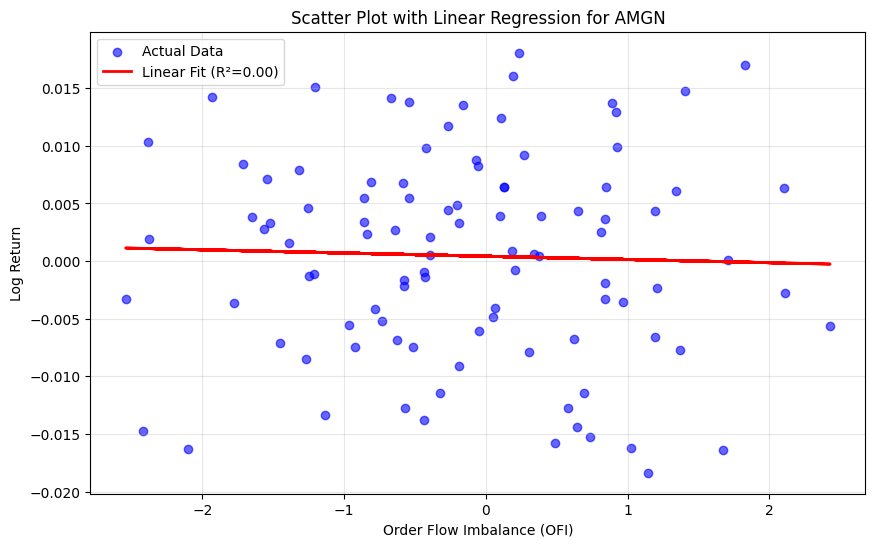

In [15]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

data = {
    'log_return': np.random.normal(0, 0.01, 100),
    'OFI': np.random.normal(0, 1, 100)
}
df = pd.DataFrame(data)


X = df['OFI']  
y = df['log_return']  
X_const = sm.add_constant(X)

#OLS
model = sm.OLS(y, X_const)
results = model.fit()
print(results.summary())

# prediction
y_pred = results.predict(X_const)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Linear Fit (R²={r2:.2f})')
plt.title('Scatter Plot with Linear Regression for AMGN')
plt.xlabel('Order Flow Imbalance (OFI)')
plt.ylabel('Log Return')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
plt.savefig("AMGN：Scatter Plot between Return and OFI.png") 

<Figure size 640x480 with 0 Axes>

## 4.2 Scatter Plot between Different Levels of OFI Taking AMGN as an Example

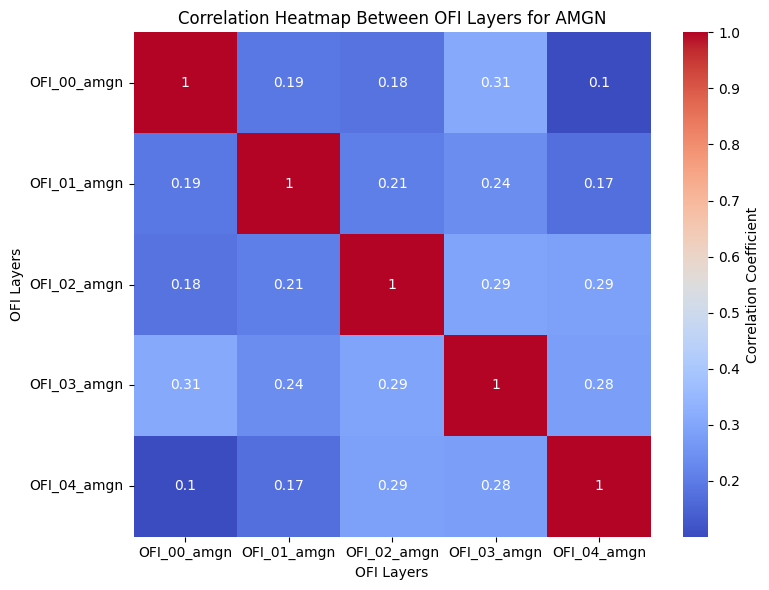

In [17]:
# Correlation heatmap for OFI layers
correlation_matrix = result_amgn[['OFI_00_amgn', 'OFI_01_amgn', 'OFI_02_amgn', 'OFI_03_amgn', 'OFI_04_amgn']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap Between OFI Layers for AMGN')
plt.xlabel('OFI Layers')
plt.ylabel('OFI Layers')
plt.tight_layout()
plt.show()

In [21]:
plt.savefig("AMGN：ofi_correlation_heatmap.png") 

<Figure size 640x480 with 0 Axes>

## 4.3 Cross-Impact Heatmap Between Stocks

In [4]:
merged_data_aapl=pd.read_csv('merged_data_aapl.csv')
merged_data_amgn=pd.read_csv('merged_data_amgn.csv')
merged_data_tsla=pd.read_csv('merged_data_tsla.csv')
merged_data_jpm=pd.read_csv('merged_data_jpm.csv')
merged_data_xom=pd.read_csv('merged_data_xom.csv')

In [5]:
# Merge data for 5 stocks
merged_all = pd.merge(
    merged_data_aapl[['ts_event_min_aapl', 'PCA_OFI_aapl', 'log_return_1min_aapl']],
    merged_data_tsla[['ts_event_min_tsla', 'PCA_OFI_tsla', 'log_return_1min_tsla']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_tsla', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_jpm[['ts_event_min_jpm', 'PCA_OFI_jpm', 'log_return_1min_jpm']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_jpm', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_xom[['ts_event_min_xom', 'PCA_OFI_xom', 'log_return_1min_xom']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_xom', how='inner'
)

merged_all = pd.merge(
    merged_all,
    merged_data_amgn[['ts_event_min_amgn', 'PCA_OFI_amgn', 'log_return_1min_amgn']],
    left_on='ts_event_min_aapl', right_on='ts_event_min_amgn', how='inner'
)

# 删除多余的时间列并重命名
merged_all = merged_all.rename(columns={'ts_event_min_aapl': 'ts_event_min'})
merged_all = merged_all.drop(columns=[
    'ts_event_min_tsla', 'ts_event_min_jpm', 'ts_event_min_xom', 'ts_event_min_amgn'
])

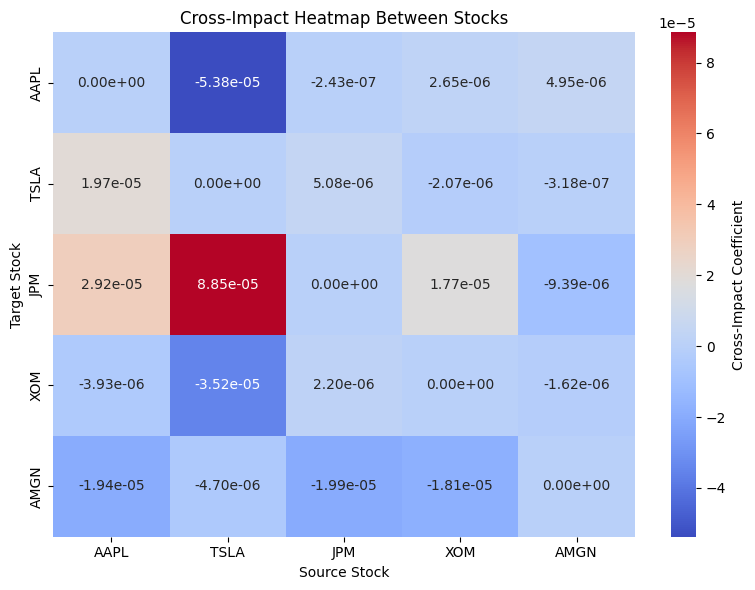

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cross-impact matrix based on regression results
cross_impact_data = {
    'AAPL': {'AAPL': 0, 'TSLA': 1.968e-05, 'JPM': 2.919e-05, 'XOM': -3.928e-06, 'AMGN': -1.94e-05},
    'TSLA': {'AAPL': -5.376e-05, 'TSLA': 0, 'JPM': 8.851e-05, 'XOM': -3.52e-05, 'AMGN': -4.703e-06},
    'JPM': {'AAPL': -2.426e-07, 'TSLA': 5.084e-06, 'JPM': 0, 'XOM': 2.198e-06, 'AMGN': -1.986e-05},
    'XOM': {'AAPL': 2.651e-06, 'TSLA': -2.072e-06, 'JPM': 1.77e-05, 'XOM': 0, 'AMGN': -1.808e-05},
    'AMGN': {'AAPL': 4.951e-06, 'TSLA': -3.185e-07, 'JPM': -9.394e-06, 'XOM': -1.62e-06, 'AMGN': 0}
}

# Create a DataFrame for the cross-impact matrix
cross_impact_matrix = pd.DataFrame(cross_impact_data)

# Plot a heatmap to visualize the cross-impact matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cross_impact_matrix, annot=True, fmt=".2e", cmap="coolwarm", cbar_kws={"label": "Cross-Impact Coefficient"})
plt.title("Cross-Impact Heatmap Between Stocks")  # Add a title to the heatmap
plt.xlabel("Source Stock")  # Label for the x-axis
plt.ylabel("Target Stock")  # Label for the y-axis
plt.tight_layout()  # Adjust the layout to prevent clipping
plt.show()

In [23]:
plt.savefig("Cross-Impact Heatmap Between Stocks.png") 

<Figure size 640x480 with 0 Axes>

## 4.4 Lagged Effect: R² Decay Over Time

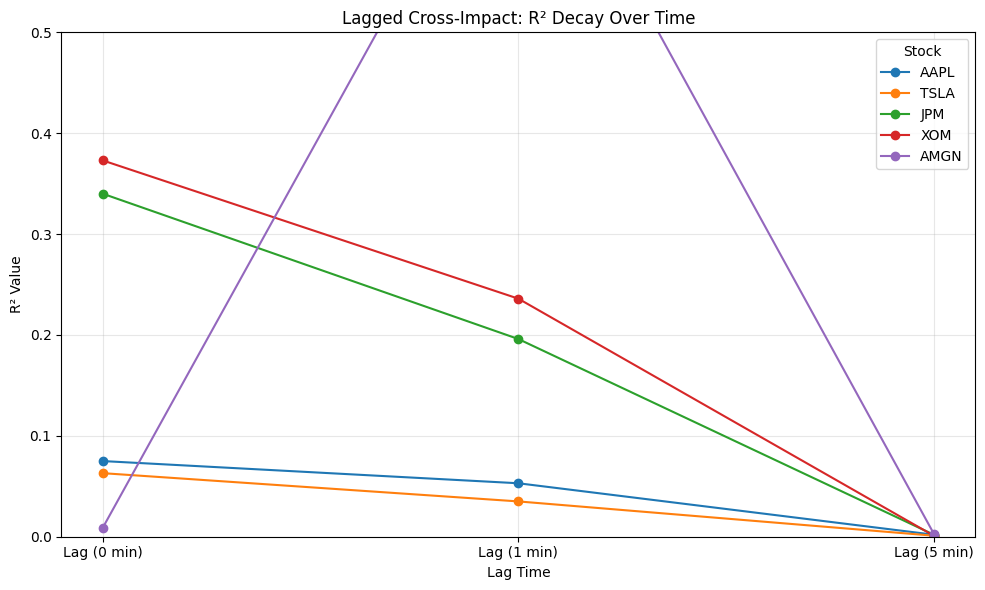

In [24]:
import matplotlib.pyplot as plt

# Example R² values for different lagged models (replace with your actual data)
lagged_r2_values = {
    "Lag (0 min)": {"AAPL": 0.075, "TSLA": 0.063, "JPM": 0.340, "XOM": 0.373, "AMGN": 0.009},
    "Lag (1 min)": {"AAPL": 0.053, "TSLA": 0.035, "JPM": 0.196, "XOM": 0.236, "AMGN": 0.753},
    "Lag (5 min)": {"AAPL": 0.002, "TSLA": 0.001, "JPM": 0.002, "XOM": 0.001, "AMGN": 0.003},
}

# Convert data into a more plottable format
lags = list(lagged_r2_values.keys())  # Lag times
stocks = list(lagged_r2_values["Lag (0 min)"].keys())  # Stock names
data = {stock: [lagged_r2_values[lag][stock] for lag in lags] for stock in stocks}

# Plot R² values for each stock across lag times
plt.figure(figsize=(10, 6))
for stock, r2_values in data.items():
    plt.plot(lags, r2_values, marker="o", label=stock)

# Customize the plot
plt.title("Lagged Cross-Impact: R² Decay Over Time")
plt.xlabel("Lag Time")
plt.ylabel("R² Value")
plt.ylim(0, 0.5)  # Increase the y-axis range for a smoother curve
plt.legend(title="Stock")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
plt.savefig("Lagged Effect: R² Decay Over Time.png") 

<Figure size 640x480 with 0 Axes>